<a href="https://colab.research.google.com/github/By0ungJoo/user_activity_analysis/blob/main/Statistical_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 간단한 데이터 설명
* Cookie: Randomly generated customer id enabling us to tie subsequent visits back to the same customer
* Timestamp: Date and time when the visit took place
* Interaction: Categorical variable indicating the type of interaction that took place
* Conversion: Boolean variable indicating whether a conversion took place
* Conversion Value: Value of the potential conversion event
* Channel: The marketing channel that brought the customer to our site


In [3]:
DRIVE_PATH = "/content/drive/MyDrive/" 
FILE_PATH_IN_MY_DRIVE = 'study/zero_base/2부/고객 유입 분석/Project_3_Statistical Analysis/data/attribution_data.csv' # 내 드라이브 내 파일이 있는 경로
PATH = DRIVE_PATH +  FILE_PATH_IN_MY_DRIVE

df = pd.read_csv(PATH) 
df.head(10) 

,cookie,time,interaction,conversion,conversion_value,channel
0,00000FkCnDfDDf0iC97iC703B,2018-07-03T13:02:11Z,impression,0,0.0,Instagram
1,00000FkCnDfDDf0iC97iC703B,2018-07-17T19:15:07Z,impression,0,0.0,Online Display
2,00000FkCnDfDDf0iC97iC703B,2018-07-24T15:51:46Z,impression,0,0.0,Online Display
3,00000FkCnDfDDf0iC97iC703B,2018-07-29T07:44:51Z,impression,0,0.0,Online Display
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03T09:44:57Z,impression,0,0.0,Paid Search
5,0000nACkD9nFkBBDECD3ki00E,2018-07-03T23:36:49Z,impression,0,0.0,Paid Search
6,0000nACkD9nFkBBDECD3ki00E,2018-07-10T22:24:41Z,impression,0,0.0,Paid Search
7,0000nACkD9nFkBBDECD3ki00E,2018-07-10T22:24:44Z,impression,0,0.0,Paid Search
8,0000nACkD9nFkBBDECD3ki00E,2018-07-11T21:21:46Z,impression,0,0.0,Paid Search
9,0000nACkD9nFkBBDECD3ki00E,2018-07-11T22:19:53Z,impression,0,0.0,Paid Search


In [4]:
df.interaction.drop_duplicates() # impression, conversion 2가지만 존재 확인 

0     impression
22    conversion
Name: interaction, dtype: object

In [5]:
df.channel.drop_duplicates() # Instagram, Online Display, Paid Search, Facebook, Online Video 5가지 존재 확인

0          Instagram
1     Online Display
4        Paid Search
18          Facebook
24      Online Video
Name: channel, dtype: object

유저 (쿠키)별로 보통 몇 개의 채널에 노출되었는지 확인하기

In [6]:
# 유저 별 unique 채널 수
df_channels_per_cookie = df.groupby('cookie').channel.nunique().reset_index()
df_channels_per_cookie.head()

,cookie,channel
0,00000FkCnDfDDf0iC97iC703B,2
1,0000nACkD9nFkBBDECD3ki00E,1
2,0003EfE37E93D0BC03iBhBBhF,1
3,00073CFE3FoFCn70fBhB3kfon,1
4,00079hhBkDF3k3kDkiFi9EFAD,1


In [7]:
# 채널수 별 유저수 확인
df_channels_per_cookie.groupby('channel').count()

,cookie
channel,
1,183020
2,45964
3,9549
4,1473
5,102


## 채널 기여도 분석
- 어떤 채널이 전환에 대한 기여도가 높은지 확인

### Last Interaction Attribution Model
- 마지막으로 노출 또는 클릭한 채널의 기여도를 100%로 계산

In [8]:
# 각 쿠키별 마지막으로 노출된 채널 확인 df_last_interaction로 저장
df_last_interaction = df.drop_duplicates('cookie', keep='last')[['cookie', 'channel', 'conversion']] 
print(len(df_last_interaction))
df_last_interaction.head()

240108


,cookie,channel,conversion
3,00000FkCnDfDDf0iC97iC703B,Online Display,0
9,0000nACkD9nFkBBDECD3ki00E,Paid Search,0
14,0003EfE37E93D0BC03iBhBBhF,Paid Search,0
15,00073CFE3FoFCn70fBhB3kfon,Instagram,0
16,00079hhBkDF3k3kDkiFi9EFAD,Paid Search,0


In [9]:
# 쿠키별 전환이 된 경우(conversion이 1일 떄) 마지막으로 노출된 채널, df_last_interaction_conv로 저장
df_last_interaction_conv = df_last_interaction.loc[df_last_interaction.conversion == 1,:] 
print(len(df_last_interaction_conv))
df_last_interaction_conv.head()

17639


,cookie,channel,conversion
22,0007oEBhnoF97AoEE3BCkFnhB,Paid Search,1
23,00090n9EBBEkA000C7Cik999D,Facebook,1
83,000h3n9nC0hFhE3CCnkkAof7n,Facebook,1
109,000hCBnCB7oi7ADAEnEBCnBEE,Online Video,1
124,000kiDB3D0fCfDAohCDB3ohko,Facebook,1


In [10]:
# 각 채널별 전환된 쿠키 갯수 확인
last_interaction_attrib = df_last_interaction_conv.groupby('channel')['cookie'].count().reset_index().rename(columns={"cookie": "attribution"})
last_interaction_attrib

,channel,attribution
0,Facebook,5301
1,Instagram,2244
2,Online Display,2139
3,Online Video,3408
4,Paid Search,4547


### First Interaction Attribution Model
- 첫번쨰로 노출된 채널이 전환에 100% 기여했다고 계산 

In [11]:
# 유저별 처음으로 노출된 채널 확인, df_first_interaction로 저장 
df_first_interaction = df.drop_duplicates('cookie', keep='first')[['cookie', 'channel', 'conversion']]
print(len(df_first_interaction))
df_first_interaction.head()

240108


,cookie,channel,conversion
0,00000FkCnDfDDf0iC97iC703B,Instagram,0
4,0000nACkD9nFkBBDECD3ki00E,Paid Search,0
10,0003EfE37E93D0BC03iBhBBhF,Paid Search,0
15,00073CFE3FoFCn70fBhB3kfon,Instagram,0
16,00079hhBkDF3k3kDkiFi9EFAD,Paid Search,0


In [12]:
# Last Intersaction Attribution Model에서 구했던 전환데이터를 활용하여 merge, df_first_interaction_conv로 저장
df_first_interaction_conv = df_first_interaction[['cookie', 'channel']].merge(df_last_interaction_conv[['cookie', 'conversion']], on='cookie')
print(len(df_first_interaction_conv))
df_first_interaction_conv.head()

17639


,cookie,channel,conversion
0,0007oEBhnoF97AoEE3BCkFnhB,Paid Search,1
1,00090n9EBBEkA000C7Cik999D,Facebook,1
2,000h3n9nC0hFhE3CCnkkAof7n,Facebook,1
3,000hCBnCB7oi7ADAEnEBCnBEE,Online Video,1
4,000kiDB3D0fCfDAohCDB3ohko,Facebook,1


In [13]:
# 각 채널별 전환된 쿠키 갯수 확인
first_interaction_attrib = df_first_interaction_conv.groupby('channel')['cookie'].count().reset_index().rename(columns={"cookie": "attribution"})
first_interaction_attrib

,channel,attribution
0,Facebook,5177
1,Instagram,2329
2,Online Display,2160
3,Online Video,3216
4,Paid Search,4757


### Linear Interaction Attribution Model
- 전환되면서 노출된 모든 채널의 기여도가 균등하다고 계산
- ex. 채널에 1개에 노출됐다면 기여도 1, 2개라면 각 0.5씩 계산 


In [14]:
# 각 유저별 채널별 데이터 중복 제거, df_uniq_chl로 저장
df_uniq_chl = df.drop_duplicates(['cookie', 'channel'], keep='last')[['cookie', 'channel']]
print(len(df_uniq_chl))
df_uniq_chl.head()

309997


,cookie,channel
0,00000FkCnDfDDf0iC97iC703B,Instagram
3,00000FkCnDfDDf0iC97iC703B,Online Display
9,0000nACkD9nFkBBDECD3ki00E,Paid Search
14,0003EfE37E93D0BC03iBhBBhF,Paid Search
15,00073CFE3FoFCn70fBhB3kfon,Instagram


In [15]:
# 유저별 채널 갯수 확인, df_uniq_chl_cnt로 저장
df_uniq_chl_cnt = df_uniq_chl.groupby('cookie').count().rename(columns = {"channel": "channel_cnt"}).reset_index()
print(len(df_uniq_chl_cnt))
df_uniq_chl_cnt.head()

240108


,cookie,channel_cnt
0,00000FkCnDfDDf0iC97iC703B,2
1,0000nACkD9nFkBBDECD3ki00E,1
2,0003EfE37E93D0BC03iBhBBhF,1
3,00073CFE3FoFCn70fBhB3kfon,1
4,00079hhBkDF3k3kDkiFi9EFAD,1


In [16]:
# merge를 통해 유저, 채널, 채널 수 확인, 총 갯수 309997이어야함, df_uniq_chl_total로 저장
df_uniq_chl_total = df_uniq_chl.merge(df_uniq_chl_cnt, on = 'cookie')
print(len(df_uniq_chl_total))
df_uniq_chl_total.head()

309997


,cookie,channel,channel_cnt
0,00000FkCnDfDDf0iC97iC703B,Instagram,2
1,00000FkCnDfDDf0iC97iC703B,Online Display,2
2,0000nACkD9nFkBBDECD3ki00E,Paid Search,1
3,0003EfE37E93D0BC03iBhBBhF,Paid Search,1
4,00073CFE3FoFCn70fBhB3kfon,Instagram,1


In [17]:
# 전환 데이터와 merge, df_linear_interaction_conv로 저장
df_linear_interaction_conv = df_uniq_chl_total.merge(df_last_interaction_conv[['cookie', 'conversion']], on='cookie')
len(df_linear_interaction_conv)
df_linear_interaction_conv.head()

,cookie,channel,channel_cnt,conversion
0,0007oEBhnoF97AoEE3BCkFnhB,Paid Search,1,1
1,00090n9EBBEkA000C7Cik999D,Facebook,1,1
2,000h3n9nC0hFhE3CCnkkAof7n,Facebook,1,1
3,000hCBnCB7oi7ADAEnEBCnBEE,Instagram,2,1
4,000hCBnCB7oi7ADAEnEBCnBEE,Online Video,2,1


In [18]:
# 각 채널 갯수별로 divide
df_linear_interaction_conv['linear_attr'] = df_linear_interaction_conv.conversion.divide(df_linear_interaction_conv.channel_cnt)

In [19]:
df_linear_interaction_conv.head()

,cookie,channel,channel_cnt,conversion,linear_attr
0,0007oEBhnoF97AoEE3BCkFnhB,Paid Search,1,1,1.0
1,00090n9EBBEkA000C7Cik999D,Facebook,1,1,1.0
2,000h3n9nC0hFhE3CCnkkAof7n,Facebook,1,1,1.0
3,000hCBnCB7oi7ADAEnEBCnBEE,Instagram,2,1,0.5
4,000hCBnCB7oi7ADAEnEBCnBEE,Online Video,2,1,0.5


In [20]:
# 채널별 기여도 확인
linear_interaction_attrib = df_linear_interaction_conv.groupby('channel')['linear_attr'].sum().reset_index().rename(columns={"linear_attr": "attribution"})
linear_interaction_attrib

,channel,attribution
0,Facebook,4947.600000
1,Instagram,2627.100000
2,Online Display,2143.600000
3,Online Video,3192.183333
4,Paid Search,4728.516667


### 3가지 기여도 분석 비교(First, Last, Linear) 

In [21]:
last_interaction_attrib["method"] = "last"
first_interaction_attrib["method"] = "first"
linear_interaction_attrib["method"] = "linear"

In [22]:
# first, last, linear 분석 하나의 데이터프레임으로 병합
total_data = last_interaction_attrib.append(first_interaction_attrib, ignore_index=True).append(linear_interaction_attrib, ignore_index=True)
total_data

,channel,attribution,method
0,Facebook,5301.000000,last
1,Instagram,2244.000000,last
2,Online Display,2139.000000,last
3,Online Video,3408.000000,last
4,Paid Search,4547.000000,last
5,Facebook,5177.000000,first
6,Instagram,2329.000000,first
7,Online Display,2160.000000,first
8,Online Video,3216.000000,first
9,Paid Search,4757.000000,first


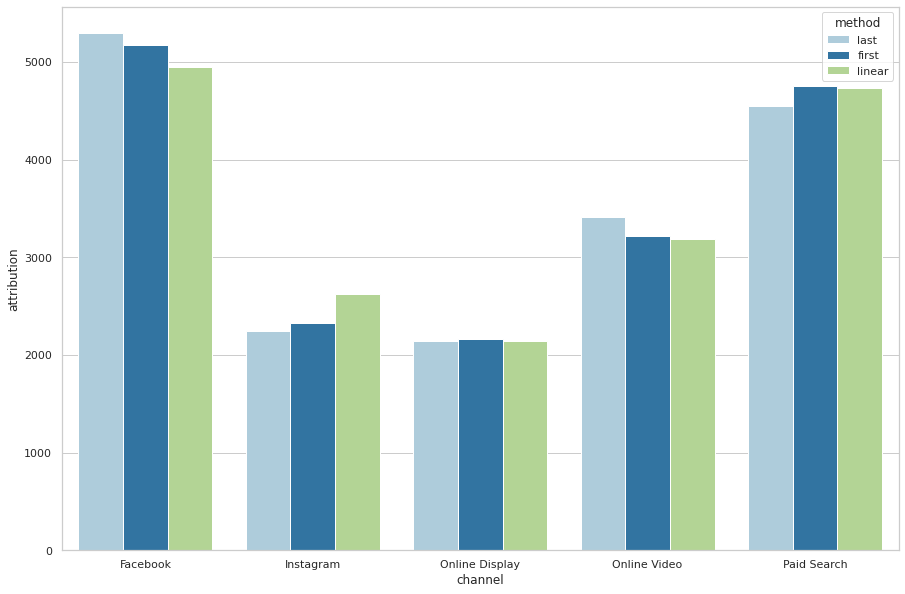

In [23]:
# 그래프로 각 분석 비교
sns.set_theme(style="whitegrid", palette="Paired") 
g = sns.barplot(x=total_data.channel, y=total_data.attribution, hue = total_data.method)
g.figure.set_size_inches(15, 10)

# Markov Chain을 이용한 기여도 분석

## 각 채널로 움직이는 전이 확률(Transition Probability) 확인

In [24]:
# 유저 별로 접한 채널을 리스트 모아둠
df_paths = df.groupby('cookie')['channel'].aggregate(lambda x: x.unique().tolist()).reset_index()  
df_paths.head()

,cookie,channel
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display]"
1,0000nACkD9nFkBBDECD3ki00E,[Paid Search]
2,0003EfE37E93D0BC03iBhBBhF,[Paid Search]
3,00073CFE3FoFCn70fBhB3kfon,[Instagram]
4,00079hhBkDF3k3kDkiFi9EFAD,[Paid Search]


In [25]:
# 채널 종류 확인 
df.channel.unique().tolist()

['Instagram', 'Online Display', 'Paid Search', 'Facebook', 'Online Video']

In [26]:
# 유저 별 전환 여부, df_last_interaction로 저장 
df_last_interaction = df.drop_duplicates('cookie', keep='last')[['cookie', 'conversion']]
df_last_interaction.head()

,cookie,conversion
3,00000FkCnDfDDf0iC97iC703B,0
9,0000nACkD9nFkBBDECD3ki00E,0
14,0003EfE37E93D0BC03iBhBBhF,0
15,00073CFE3FoFCn70fBhB3kfon,0
16,00079hhBkDF3k3kDkiFi9EFAD,0


In [27]:
# df_path에 전환 여부(df_last_interaction) 병합
df_paths = pd.merge(df_paths, df_last_interaction, how='left', on='cookie')
df_paths.head()

,cookie,channel,conversion
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display]",0
1,0000nACkD9nFkBBDECD3ki00E,[Paid Search],0
2,0003EfE37E93D0BC03iBhBBhF,[Paid Search],0
3,00073CFE3FoFCn70fBhB3kfon,[Instagram],0
4,00079hhBkDF3k3kDkiFi9EFAD,[Paid Search],0


Markov Chain State 종류
* Start: 노출 시작 
* Instagram: 인스타그램 광고
* Paid Search: 유료 검색 광고
* Facebook: 페이스북 광고
* Online Video: 비디오형 광고
* Online Display: 배너 노출 광고
* Conversion: 전환 성공 (구매 완료)
* Null: 전환 실패 (구매 없이 나감)


In [28]:
# paths에 앞에서는 Start 마지막에는 전환여부에 따라 Null, Conversion 추가 
df_paths['paths'] = df_paths.apply(lambda x: ['Start'] + x.channel + ['Null'] if x.conversion == 0 else ['Start'] + x.channel + ['Conversion'], axis=1)
df_paths.head()

,cookie,channel,conversion,paths
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display]",0,"[Start, Instagram, Online Display, Null]"
1,0000nACkD9nFkBBDECD3ki00E,[Paid Search],0,"[Start, Paid Search, Null]"
2,0003EfE37E93D0BC03iBhBBhF,[Paid Search],0,"[Start, Paid Search, Null]"
3,00073CFE3FoFCn70fBhB3kfon,[Instagram],0,"[Start, Instagram, Null]"
4,00079hhBkDF3k3kDkiFi9EFAD,[Paid Search],0,"[Start, Paid Search, Null]"


In [29]:
# 총 쿠키 수(cookie_count)전환된 쿠키 수(conversion_count) 확인
cookie_count = len(df_paths)
conversion_count = len(df_paths.loc[df_paths.conversion == 1, :])
print(cookie_count)
print(conversion_count)

240108
17639


In [30]:
# 전체 전환율은 7%정도 되는 것을 확인 / 0.07346277508454528
basic_conversion_rate = conversion_count / cookie_count
print(basic_conversion_rate)

0.07346277508454528


In [31]:
# transition 확률을 구하기 위한 데이터
list_of_paths = df_paths['paths']

In [32]:
# 이벤트 종류 확인 
list_of_unique_channels = set(x for element in list_of_paths for x in element)
list_of_unique_channels

{'Conversion',
 'Facebook',
 'Instagram',
 'Null',
 'Online Display',
 'Online Video',
 'Paid Search',
 'Start'}

각 이벤트에서 다음 이벤트로 넘어가는 갯수 확인
- dict 형태로 확인

In [33]:
def transition_states(list_of_paths):
    # State 종류 확인 
    list_of_unique_channels = set(x for element in list_of_paths for x in element)

    # 갯수를 세기 전에 0으로 설정
    transition_states = {x + '>' + y: 0 for x in list_of_unique_channels for y in list_of_unique_channels}
    
    # State>State 갯수 확인
    for possible_state in list_of_unique_channels:
        if possible_state not in ['Conversion', 'Null']:
            for user_path in list_of_paths:
                if possible_state in user_path:
                    indices = [i for i, s in enumerate(user_path) if possible_state in s]
                    for col in indices:
                        transition_states[user_path[col] + '>' + user_path[col + 1]] += 1

    return transition_states


trans_states = transition_states(list_of_paths)
trans_states

{'Conversion>Conversion': 0,
 'Conversion>Facebook': 0,
 'Conversion>Instagram': 0,
 'Conversion>Null': 0,
 'Conversion>Online Display': 0,
 'Conversion>Online Video': 0,
 'Conversion>Paid Search': 0,
 'Conversion>Start': 0,
 'Facebook>Conversion': 4690,
 'Facebook>Facebook': 0,
 'Facebook>Instagram': 15252,
 'Facebook>Null': 59319,
 'Facebook>Online Display': 2146,
 'Facebook>Online Video': 2254,
 'Facebook>Paid Search': 4464,
 'Facebook>Start': 0,
 'Instagram>Conversion': 2868,
 'Instagram>Facebook': 10822,
 'Instagram>Instagram': 0,
 'Instagram>Null': 31153,
 'Instagram>Online Display': 1164,
 'Instagram>Online Video': 1193,
 'Instagram>Paid Search': 2266,
 'Instagram>Start': 0,
 'Null>Conversion': 0,
 'Null>Facebook': 0,
 'Null>Instagram': 0,
 'Null>Null': 0,
 'Null>Online Display': 0,
 'Null>Online Video': 0,
 'Null>Paid Search': 0,
 'Null>Start': 0,
 'Online Display>Conversion': 2144,
 'Online Display>Facebook': 2300,
 'Online Display>Instagram': 1251,
 'Online Display>Null': 322

확률로 정의해보자
* transition probability 로 정의하려면, 각 채널에서 다음 채널로 가는 수를 다 더해서 나눠준다.

In [38]:
def transition_prob(trans_dict):
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    trans_prob = defaultdict(dict)
    for state in list_of_unique_channels: 
        if state not in ['Conversion', 'Null']:
            # trans_dict 에서 각 채널에서 다른 채널로 가는 상태를 가져온다.
            next_states_from_state = [s for s in trans_dict if state + '>' in s]
            counter = 0

            for next_state in next_states_from_state:
                state 
                if trans_dict[next_state] > 0:
                    counter += trans_dict[next_state]

            for next_state in next_states_from_state:
                if trans_dict[next_state] > 0:
                    state_prob = float((trans_dict[next_state])) / float(counter)
                    trans_prob[next_state] = state_prob
    return trans_prob


trans_prob = transition_prob(trans_states)

In [39]:
trans_prob

defaultdict(dict,
            {'Facebook>Conversion': 0.053219858156028366,
             'Facebook>Instagram': 0.1730723404255319,
             'Facebook>Null': 0.6731234042553191,
             'Facebook>Online Display': 0.02435177304964539,
             'Facebook>Online Video': 0.025577304964539006,
             'Facebook>Paid Search': 0.05065531914893617,
             'Instagram>Conversion': 0.057979218048760765,
             'Instagram>Facebook': 0.2187765333764606,
             'Instagram>Null': 0.6297861157158452,
             'Instagram>Online Display': 0.023531314438199977,
             'Instagram>Online Video': 0.024117575708567502,
             'Instagram>Paid Search': 0.04580924271216593,
             'Online Display>Conversion': 0.05032391324758239,
             'Online Display>Facebook': 0.053985541263731104,
             'Online Display>Instagram': 0.02936344005257722,
             'Online Display>Null': 0.7566425687728852,
             'Online Display>Online Video': 0.017

## 전이확률행렬(Transition Probability Matrix)로 만들기

In [40]:
# 행령 모양 데이터 프레임 생성
trans_matrix = pd.DataFrame()
trans_matrix

""


In [44]:
# Conversion, Null 경우 1, 그외는 0.00(확률을 구할거라 float)
for channel in list_of_unique_channels:
    trans_matrix[channel] = 0.00
    trans_matrix.loc[channel] = 0.00

    # 자기 자신으로 가는 확률을 부여한다.
    trans_matrix.loc[channel][channel] = 1.0 if channel in ['Conversion', 'Null'] else 0.0


In [45]:
trans_matrix

,Instagram,Start,Conversion,Paid Search,Facebook,Online Video,Null,Online Display
Instagram,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Start,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Conversion,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Paid Search,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Facebook,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Online Video,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Null,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Online Display,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
# 데이터프레임에 해당 채널의 데이터를 넣음
for key, value in trans_prob.items():
    origin, destination = key.split('>')
    trans_matrix.at[origin, destination] = value

In [48]:
trans_matrix

,Instagram,Start,Conversion,Paid Search,Facebook,Online Video,Null,Online Display
Instagram,0.000000,0.0,0.057979,0.045809,0.218777,0.024118,0.629786,0.023531
Start,0.119188,0.0,0.000000,0.317399,0.278408,0.142361,0.000000,0.142644
Conversion,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Paid Search,0.034196,0.0,0.053309,0.000000,0.064442,0.029221,0.770779,0.048053
Facebook,0.173072,0.0,0.053220,0.050655,0.000000,0.025577,0.673123,0.024352
Online Video,0.031908,0.0,0.078146,0.047947,0.059323,0.000000,0.763757,0.018920
Null,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
Online Display,0.029363,0.0,0.050324,0.092386,0.053986,0.017299,0.756643,0.000000


역시 깔끔하게 정리하기 위해서 함수로 만들자

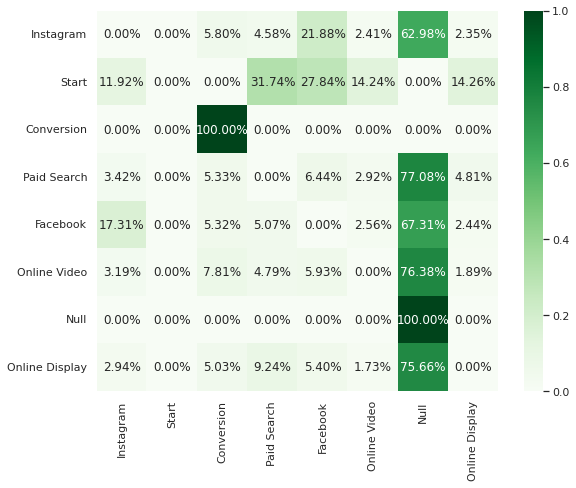

In [52]:
# heatmap으로 그려보기
g = sns.heatmap(trans_matrix, annot=True, fmt='.2%', cmap="Greens")
g.figure.set_size_inches(9, 7) # 그래프의 크기를 키운다

채널별 Removal Effect 확인

In [58]:
# Conversion, Null 빼고 나머지 State list에 담기
removal_effects_dict = {}
channels = [column for column in trans_matrix.columns if column not in ['Start', 'Null', 'Conversion']]

channels

['Instagram', 'Paid Search', 'Facebook', 'Online Video', 'Online Display']

Facebook 의 제거효과를 구해보자
- 목표: Facebook 으로 인한 전환이 다 없어졌다고 가정했을 때 전체 전환율을 구한다

- 1) Facebook 으로 인한 전환을 제거하는 일
- 2) 제거된 상태에서 전체 전환율을 다시 계산해보는 일 <- Absorbing Markov Chain 공식을 활용해 보려고 합니다

In [59]:
# Facebook이 없었을 때 전환율 확인 / Facebook이 전체 전환율에 얼마나 기여하고 있는지 확인 가능
# 기존에 만들어둔 행렬에서 Facebook을 다 지운다
channel = 'Facebook'
removal_df = trans_matrix.drop(channel, axis=1).drop(channel, axis=0)

In [61]:
# 전이행렬의 합은 1이 되어야하는데 Facebook이 빠져 1이 되지 않아 Facebook의 전환율은 Null로 주고 다시 계산
for column in removal_df.columns:
    row_sum = np.sum(list(removal_df.loc[column])) 
    null_pct = float(1) - row_sum
    print(column, row_sum, null_pct)
    if null_pct != 0:
        removal_df.loc[column]['Null'] = removal_df.loc[column]['Null'] + null_pct
    removal_df.loc['Null']['Null'] = 1.0

Instagram 0.7812234666235394 0.21877653337646064
Start 0.7215919502890366 0.27840804971096345
Conversion 1.0 0.0
Paid Search 0.9355583070688879 0.06444169293111213
Online Video 0.9406767247692983 0.05932327523070169
Null 1.0 0.0
Online Display 0.9460144587362689 0.05398554126373112


In [65]:
# 합이 1이 됐는지 확인 / 1이 된것을 확인
column = 'Paid Search'
np.sum(list(removal_df.loc[column]))

1.0

In [ ]:
# Absorbing Markov Chain 공식 하나를 이용해서
# 맨 처음에 Start 에서 시작해서 어떤 State 를 다 거치고 오더라도
# 결과적으로 Conversion으로 가는 확률값 = Facebook 을 제거했을 때 Start에서 시작한 최종적인 전환율

In [67]:
# Abosorbing States : Null, Conversion
# Transient States: 나머지 State
removal_to_conv = removal_df[['Null', 'Conversion']].drop(['Null', 'Conversion'], axis=0)

removal_to_non_conv = removal_df.drop(['Null', 'Conversion'], axis=1).drop(['Null', 'Conversion'], axis=0)

In [70]:
# Numpy array로 변경
np.asarray(removal_to_non_conv)

array([[0.        , 0.        , 0.04580924, 0.02411758, 0.02353131],
       [0.11918803, 0.        , 0.31739884, 0.14236094, 0.14264414],
       [0.03419631, 0.        , 0.        , 0.02922107, 0.04805268],
       [0.03190762, 0.        , 0.04794688, 0.        , 0.01891997],
       [0.02936344, 0.        , 0.09238569, 0.01729885, 0.        ]])

In [71]:
len(removal_to_non_conv.columns)

5

In [72]:
# 5x5 단위행렬 I로 저장 변화하는 State들은 Q로 저장 
I = np.identity(len(removal_to_non_conv.columns))
print(I)

Q = np.asarray(removal_to_non_conv)
print(Q)

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
[[0.         0.         0.04580924 0.02411758 0.02353131]
 [0.11918803 0.         0.31739884 0.14236094 0.14264414]
 [0.03419631 0.         0.         0.02922107 0.04805268]
 [0.03190762 0.         0.04794688 0.         0.01891997]
 [0.02936344 0.         0.09238569 0.01729885 0.        ]]


In [79]:
# Absorbing State를 구하기 위해 I - Q
mat = I - Q
mat

# I-Q 의 역행렬 F로 저장
removal_inv_diff = np.linalg.inv(mat)
F = np.linalg.inv(I - Q)

removal_dot_prod = np.dot(removal_inv_diff, np.asarray(removal_to_conv))

In [82]:
# 데이터 프레임으로 변경 / Start>Conversion : 0.047401 전환율이 4.7% 정도인 것을 확인
pd.DataFrame(removal_dot_prod, index=removal_to_conv.index, columns = removal_to_conv.columns)

,Null,Conversion
Instagram,0.935808,0.064192
Start,0.952599,0.047401
Paid Search,0.939185,0.060815
Online Video,0.915769,0.084231
Online Display,0.940716,0.059284


In [87]:
# 맨 처음 구했던 전체 전환율은 7.3% 
basic_conversion_rate

0.07346277508454528

In [90]:
# 전체 전환율 중 Facebook이 차지하고 있는 비중을 뺸 나머지 전환율 비중은 64& 정도인 것을 확인
removal_cvr / basic_conversion_rate

0.6452402325817279

In [92]:
# 64% 반대로 Facebook의 비중은 35%가 된다
removal_effect = 1 - removal_cvr / basic_conversion_rate
removal_effect

0.3547597674182721

모든 채널의 removal effect 를 구하자

In [96]:
# Facebook 제거 효과를 구한 것처럼 나머지 채널들도 removal effect 확인
def removal_effects(df, conversion_rate):
    removal_effects_dict = {}
    channels = [channel for channel in df.columns if channel not in ['Start',
                                                                     'Null',
                                                                     'Conversion']]
    for channel in channels:
        removal_df = df.drop(channel, axis=1).drop(channel, axis=0)
        for column in removal_df.columns:
            row_sum = np.sum(list(removal_df.loc[column]))
            null_pct = float(1) - row_sum
            if null_pct != 0:
                removal_df.loc[column]['Null'] = removal_df.loc[column]['Null'] + null_pct
            removal_df.loc['Null']['Null'] = 1.0

        removal_to_conv = removal_df[
            ['Null', 'Conversion']].drop(['Null', 'Conversion'], axis=0)
        removal_to_non_conv = removal_df.drop(
            ['Null', 'Conversion'], axis=1).drop(['Null', 'Conversion'], axis=0)

        removal_inv_diff = np.linalg.inv(
            np.identity(
                len(removal_to_non_conv.columns)) - np.asarray(removal_to_non_conv))
        removal_dot_prod = np.dot(removal_inv_diff, np.asarray(removal_to_conv))
        removal_cvr = pd.DataFrame(removal_dot_prod,
                                   index=removal_to_conv.index)[[1]].loc['Start'].values[0]
        removal_effect = 1 - removal_cvr / conversion_rate
    
        removal_effects_dict[channel] = removal_effect

    return removal_effects_dict


removal_effects_dict = removal_effects(trans_matrix, basic_conversion_rate)
removal_effects_dict

{'Facebook': 0.3547597674182721,
 'Instagram': 0.21731366149038456,
 'Online Display': 0.15435482356041275,
 'Online Video': 0.20691411655642178,
 'Paid Search': 0.3311037560086154}

In [111]:
# 각 채널 별 확률을 전체 확률(1.2644461250341066)로 나누고 총 converion count 를 곱해 실제 기여한 전환 수 계산
def markov_chain_allocations(removal_effects, total_conversions):
    re_sum = np.sum(list(removal_effects.values()))

    return {k: (v / re_sum) * total_conversions for k, v in removal_effects.items()}


attributions = markov_chain_allocations(removal_effects_dict, conversion_count)
attributions

{'Facebook': 4948.892177847523,
 'Instagram': 3031.521548555893,
 'Online Display': 2153.2469267590823,
 'Online Video': 2886.4480895461456,
 'Paid Search': 4618.891257291356}

In [112]:
attribution_by_markov = pd.DataFrame({'channel': attributions.keys(), 'attribution': attributions.values()})
attribution_by_markov

,channel,attribution
0,Instagram,3031.521549
1,Paid Search,4618.891257
2,Facebook,4948.892178
3,Online Video,2886.448090
4,Online Display,2153.246927


removal effect도 위에 그래프에 추가
- markov chain 분석으로 보니 instagram의 기여도가 높아졌다

In [114]:
attribution_by_markov["method"] = "markov"

In [115]:
total_with_markov = total_data.append(attribution_by_markov, ignore_index = True)

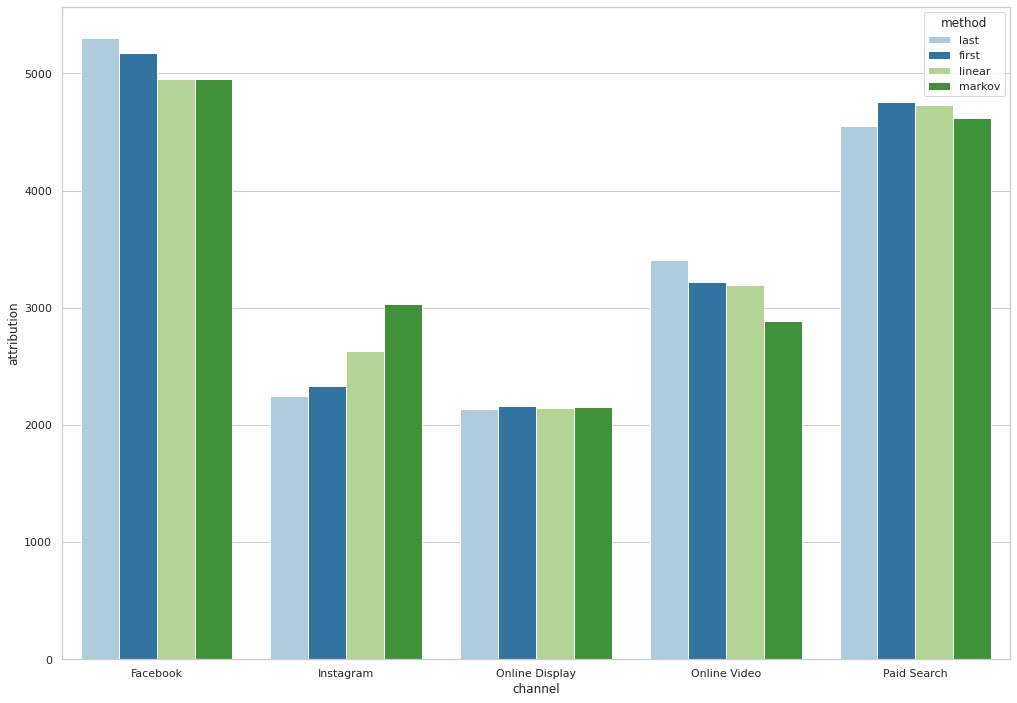

In [117]:
sns.set_theme(style="whitegrid", palette="Paired")
g = sns.barplot(x=total_with_markov.channel, y=total_with_markov.attribution, hue = total_with_markov.method)
g.figure.set_size_inches(17, 12)